## Neural style transfer

Neural Style Transfer (NST) is a fascinating technique that combines the style of one image with the content of another to create a new image. Using deep learning, NST leverages pre-trained convolutional neural networks (CNNs) to extract and blend style and content features from images.

In this notebook, we will:
- Explore the concepts behind NST.
- Utilize a pre-trained model to implement NST.
- Create unique, stylized images by merging our chosen content and style images.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### 1. Helper functions

In [2]:
def get_image(path, transform, size=(300,300)):

    image = Image.open(path)
    image = image.resize(size)
    image = transform(image)
    image = image.unsqueeze(0)  # Adding an extra dimension for the batch
    return image

def get_gram(m):
    """
        m is of shape (1, C, H, W)
    """
    _, c, h, w = m.size()
    m = m.view(c, h * w) # 2D
    m = torch.mm(m, m.t()) # Matrix multiplication
    return m

def denormalization(x):

    x = x.numpy() # From PyTorch to Numpy
    x = x.transpose((1,2,0))  # C,H,W --> H,W,C

    mean  = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    x = std * x + mean
    x = np.clip(x, 0, 1)
    return x

### 2. Model

![figure](https://user-images.githubusercontent.com/30661597/107026142-96fa0100-67aa-11eb-9f71-4adce01dd362.png)

In [3]:
vgg16 = models.vgg16(pretrained=True)
vgg16.features

c:\Users\Lenovo\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [4]:
vgg16.features._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

This case we ar going to choose the layers after the ReLU activaiton function [3,8,15,22, 25, 27, 29], when the non-linearity is applied to the model.

In [5]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.selected_layers = [3, 8, 15, 22, 25, 27, 29]
        self.vgg16 = models.vgg16(pretrained=True).features
    
    def forward(self, x):
        layer_feats = []

        for layer_num, layer in self.vgg16._modules.items():
            x = layer(x)

            if int(layer_num) in self.selected_layers:
                layer_feats.append(x)
        
        return layer_feats

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406), 
        std=(0.229, 0.224, 0.225)
        )
        ])

content_img = get_image('content.jpg', img_transform)
style_img = get_image('style.png', img_transform)

generated_img = content_img.clone()    # or nn.Parameter(torch.FloatTensor(content_img.size()))
# In this case better start with content image (makes life easier)

# requires_grad = True makes the image learnable
generated_img.requires_grad = True


optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor()

# For this case we do not want the encoder to be trianed, already we have the labels
for p in encoder.parameters():
    p.requires_grad = False

In [7]:
content_weight = 1
style_weight = 100

for epoch in range(500):

    # First we encode the 3 images
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean(
        (content_features[-1] - generated_features[-1]).pow(2)
        )  

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean(
            (gram_gf - gram_sf)**2)  / (c * h * w) # Normalization of the values

    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss: 0.0000	Style Loss: 2737.3499
Epoch [10]	Content Loss: 0.0337	Style Loss: 2262.2671
Epoch [20]	Content Loss: 0.0870	Style Loss: 1897.7285
Epoch [30]	Content Loss: 0.1339	Style Loss: 1614.1766
Epoch [40]	Content Loss: 0.1749	Style Loss: 1394.4998
Epoch [50]	Content Loss: 0.2121	Style Loss: 1221.9260
Epoch [60]	Content Loss: 0.2474	Style Loss: 1082.5214
Epoch [70]	Content Loss: 0.2801	Style Loss: 967.3589
Epoch [80]	Content Loss: 0.3097	Style Loss: 870.7156
Epoch [90]	Content Loss: 0.3348	Style Loss: 788.7805
Epoch [100]	Content Loss: 0.3564	Style Loss: 718.6040
Epoch [110]	Content Loss: 0.3749	Style Loss: 657.9079
Epoch [120]	Content Loss: 0.3923	Style Loss: 604.8334
Epoch [130]	Content Loss: 0.4081	Style Loss: 558.0318
Epoch [140]	Content Loss: 0.4221	Style Loss: 516.4366
Epoch [150]	Content Loss: 0.4348	Style Loss: 479.2303
Epoch [160]	Content Loss: 0.4463	Style Loss: 445.7379
Epoch [170]	Content Loss: 0.4572	Style Loss: 415.4087
Epoch [180]	Content Loss: 0.4665

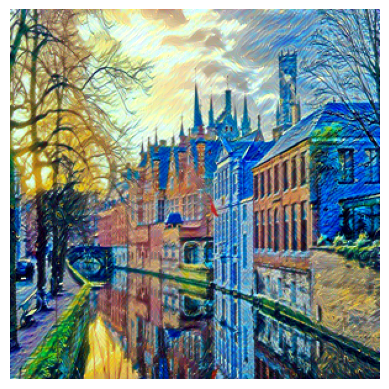

In [10]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalization(inp)
plt.imshow(inp)
plt.axis('off');  # Hides the axis